First We import our required libraries

In [ ]:
!pip install symspellpy
!pip install fast_ml
#!pip install -U nltk
#!pip install -U scikit-learn
#!pip install -U gensim
#!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 KB 13.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 2.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

import re # The following statement imports the regex package.
import gensim # The following statement imports the gensim package.
import nltk # The following statement imports the NLTK package.
import pkg_resources
import pandas as pd
import os
import numpy as np
from symspellpy import SymSpell, Verbosity
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer



We mount the google drive here and navigate to the folder


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

list_files = []
for file in os.listdir():
  if file.endswith('.csv'):  
    print(file)


Mounted at /content/gdrive


We navigate to our desired folder and list the files

In [ ]:
%cd gdrive/MyDrive/TxtAnalytics_Proj
#list_files = []
#for file in os.listdir():
#   print(file)

#!cat 'TextPreprocessor_CSV.py'

/content/gdrive/MyDrive/TxtAnalytics_Proj


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')



Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:

fileName = "Suicide_Detection.csv"
isFileExist = os.path.isfile(fileName)

if(isFileExist == True):
   posts = pd.read_csv(fileName)
else:
  print("File not found: " + os.getcwd() + fileName)



Pre processing

In [ ]:
print(posts.head())
 #drop data with empty data points
posts['text'].replace('', np.nan, inplace=True)
posts['class'].replace('', np.nan, inplace=True)
posts.dropna(subset=['text'], inplace=True)
posts.dropna(subset=['class'], inplace=True)

#to lower case
posts['text'] = posts['text'].str.lower()

#remove punctuation and numbers
posts['text'] = posts['text'].apply(lambda t: re.sub(r'[^a-zA-Z ]', '', t))

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


import train_test_split() and NumPy before you can use them, so you an start with the import statements

Remove stop words and correct typo

In [ ]:
#remove stop words first round, this is to reduce the number of words that symspell need to process...
#however typo cannot be removed
posts['text'] = posts['text'].apply(lambda t: gensim.parsing.preprocessing.remove_stopwords(str(t)))

symsp = SymSpell(max_dictionary_edit_distance=1, prefix_length=7) #Damerau-Levenshtein algorithm = 2, Levenshtein = 1
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
symsp.load_dictionary(dictionary_path, term_index=0, count_index=1)
posts['text'] = posts['text'].apply(lambda t: symsp.lookup_compound(t, max_edit_distance=1)[0].term )



In [ ]:
posts['text'] = posts['text'].apply(lambda t: gensim.parsing.preprocessing.remove_stopwords(str(t)))
print(posts.head())
posts.to_pickle("posts_after_symspell")

   Unnamed: 0                                               text        class
0           2  sex wife threatening suicide recently left wif...      suicide
1           3  weird affected compliments coming know girl fe...  non-suicide
2           4   finally hear bad year swear fucking god annoying  non-suicide
3           8                         need help help crying hard      suicide
4           9  lost hello adam live struggling years afraid p...      suicide


In [ ]:
def get_wordnet_pos(treebank_tag):
  """
  return WORDNET POS compliance to WORDNET lemmatization (a,n,r,v) 
  """
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
  # As default pos in lemmatization is Noun
    return wordnet.NOUN

def pos_tag_and_lemmatize(sentence):
# find the pos tagging for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....

  pos_tokens = [nltk.pos_tag(word_tokenize(sentence))]
  lemmatizer = WordNetLemmatizer()
  # lemmatization using pos tag  
  pos_tokens = [ [(token, lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag)), [pos_tag]) for (token,pos_tag) in pos] for pos in pos_tokens]
  return pos_tokens

def getLemmatizedText(pos_tag):
  lst = list()
  for postag_tuple in pos_tag:
    for p in postag_tuple:
      value = re.sub(r'[^a-zA-Z ]', '', p[1])
      lst.append(value)

  return lst

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
 #lemmatization, note: Lemmatization includes stemming as discussed in class.
posts['text_lemmatized_with_postag'] = posts['text'].apply(lambda t: pos_tag_and_lemmatize(t))

posts['text_lemmatized'] = posts['text_lemmatized_with_postag'].apply(lambda t: getLemmatizedText(t))

posts.to_pickle("posts_after_lemmatized")

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/TxtAnalytics_Proj')
from TextPreprocessor_CSV import TextPreprocessor_CSV

fileName = "posts_after_lemmatized.pkl"
isFileExist = os.path.isfile(fileName)

if(isFileExist == True):
   posts = pd.read_pickle(fileName)
else:
   print("File not found: " + os.getcwd() + fileName)


V

In [ ]:
def generateVectors(posts, yseries, filename):
         #create dictionary
        all_docs5 = []

        suicidal_data_TFIDF = list()
        suicidal_data_TF = list()

        non_suicidal_data_TF = list()
        non_suicidal_data_TFIDF = list()

        #create corpus dictionary
        corpus_dictionary = gensim.corpora.Dictionary()
        
        for i in range(len(posts)):
            value = posts.iloc[i, posts.columns.get_loc("text_lemmatized")]
            #print(value)
            all_docs5.append(value) #df.iloc[0, df.columns.get_loc("a")]
            
        corpus_dictionary.add_documents(all_docs5)
        
        # Convert all documents to term frequency (TF) vectors
        all_tf_vectors = [corpus_dictionary.doc2bow(doc) for doc in all_docs5]

        #ntc = n = raw, t = zero-corrected idf, c = cosine - https://radimrehurek.com/gensim/models/tfidfmodel.html
        tfidf = gensim.models.TfidfModel(all_tf_vectors, smartirs='ntc')
        corpus_tfidf = tfidf[all_tf_vectors]
        
        all_data_as_dict = [{id:tf_value for (id, tf_value) in vec} for vec in all_tf_vectors]
        tfidf_data_as_dict = [{id:tf_value for (id, tf_value) in vec} for vec in corpus_tfidf]
       
        for i in range(len(all_data_as_dict)):
            doc_tf = all_data_as_dict[i]
            doc_tfidf = tfidf_data_as_dict[i]
            doc_label = yseries.iloc[i]

            if(doc_label == 1):
                suicidal_data_TF.append((doc_tf, 1))
                suicidal_data_TFIDF.append((doc_tfidf, 1))

            else:
                non_suicidal_data_TF.append((doc_tf, 0))
                non_suicidal_data_TFIDF.append((doc_tfidf, 0))
      
        print(suicidal_data_TFIDF)
        posts['tf_vector'] = suicidal_data_TF + non_suicidal_data_TF
        posts['tfidf_vector']  = suicidal_data_TFIDF + non_suicidal_data_TFIDF

        posts.to_pickle(filename)

        corpus_dictionary.save(filename.replace(".pkl", ".dict"))

In [ ]:
posts["class"] = posts["class"].apply(lambda x: 1 if x =="suicide" else 0)
from fast_ml.model_development import train_valid_test_split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(posts, target = 'class', 
                                                                            train_size=0.7, valid_size=0.2, test_size=0.1)



Initialize all empty data frame

In [ ]:
print(X_train.shape)
print(y_train.count)

(162451, 4)
<bound method Series.count of 168932    1
24668     1
117789    0
163593    0
216657    1
         ..
153899    1
230611    1
72931     1
133952    0
124717    0
Name: class, Length: 162451, dtype: int64>


In [ ]:
post_split_Train_X = np.array_split(X_train, 5)
post_split_Train_Y = np.array_split(y_train, 5)

post_split_Valid_X_ = np.array_split(X_valid, 5)
post_split_Valid_Y = np.array_split(y_valid, 5)

post_split_Test_X_ = np.array_split(X_test, 5)
post_split_Test_Y = np.array_split(y_test, 5)



In [ ]:
print(post_split_Train_X[0].shape)
print(post_split_Train_Y[0].count)

for k in range(len(post_split_Train_Y)):
  setNo = k+1
  post_split_Train_X[k].to_pickle("post_split_Train_X_" + str(setNo) + ".pkl")
  post_split_Train_Y[k].to_pickle("post_split_Train_Y_" + str(setNo) + ".pkl")

for k in range(len(post_split_Valid_Y)):
  setNo = k+1
  post_split_Valid_X_[k].to_pickle("post_split_Valid_X_" + str(setNo) + ".pkl")
  post_split_Valid_Y[k].to_pickle("post_split_Valid_Y_" + str(setNo) + ".pkl")

for k in range(len(post_split_Test_Y)):
  setNo = k+1
  post_split_Test_X_[k].to_pickle("post_split_Test_X_" + str(setNo) + ".pkl")
  post_split_Test_Y[k].to_pickle("post_split_Test_Y_" + str(setNo) + ".pkl")

#.to_pickle("posts_after_symspell")

(32491, 4)
<bound method Series.count of 168932    1
24668     1
117789    0
163593    0
216657    1
         ..
106439    1
101586    1
159482    1
127603    1
5003      0
Name: class, Length: 32491, dtype: int64>


In [ ]:
Read the saved pickle files for X Values

In [ ]:
train1 = post_split_Train_X1 = pd.read_pickle("post_split_Train_X_1.pkl")
train2 = post_split_Train_X2 = pd.read_pickle("post_split_Train_X_2.pkl")
train3 = post_split_Train_X3 = pd.read_pickle("post_split_Train_X_3.pkl")
train4 = post_split_Train_X4 = pd.read_pickle("post_split_Train_X_4.pkl")
train5 = post_split_Train_X5 = pd.read_pickle("post_split_Train_X_5.pkl")

Valid1 = post_split_Valid_X1 = pd.read_pickle("post_split_Valid_X_1.pkl")
Valid2 = post_split_Valid_X2 = pd.read_pickle("post_split_Valid_X_2.pkl")
Valid3 = post_split_Valid_X3 = pd.read_pickle("post_split_Valid_X_3.pkl")
Valid4 = post_split_Valid_X4 = pd.read_pickle("post_split_Valid_X_4.pkl")
Valid5 = post_split_Valid_X5 = pd.read_pickle("post_split_Valid_X_5.pkl")

Test1 = post_split_Test_X1 = pd.read_pickle("post_split_Test_X_1.pkl")
Test2 = post_split_Test_X2 = pd.read_pickle("post_split_Test_X_2.pkl")
Test3 = post_split_Test_X3 = pd.read_pickle("post_split_Test_X_3.pkl")
Test4 = post_split_Test_X4 = pd.read_pickle("post_split_Test_X_4.pkl")
Test5 = post_split_Test_X5 = pd.read_pickle("post_split_Test_X_5.pkl")



Read the saved pickle files for Y Values (Response Variable)

In [ ]:
train1_Y = post_split_Train_Y1 = pd.read_pickle("post_split_Train_Y_1.pkl")
train2_Y = post_split_Train_Y2 = pd.read_pickle("post_split_Train_Y_2.pkl")
train3_Y = post_split_Train_Y3 = pd.read_pickle("post_split_Train_Y_3.pkl")
train4_Y = post_split_Train_Y4 = pd.read_pickle("post_split_Train_Y_4.pkl")
train5_Y = post_split_Train_Y5 = pd.read_pickle("post_split_Train_Y_5.pkl")

Valid1_Y = post_split_Valid_Y1 = pd.read_pickle("post_split_Valid_Y_1.pkl")
Valid2_Y = post_split_Valid_Y2 = pd.read_pickle("post_split_Valid_Y_2.pkl")
Valid3_Y = post_split_Valid_Y3 = pd.read_pickle("post_split_Valid_Y_3.pkl")
Valid4_Y = post_split_Valid_Y4 = pd.read_pickle("post_split_Valid_Y_4.pkl")
Valid5_Y = post_split_Valid_Y5 = pd.read_pickle("post_split_Valid_Y_5.pkl")

Test1_Y = post_split_Test_Y1 = pd.read_pickle("post_split_Test_Y_1.pkl")
Test2_Y = post_split_Test_Y2 = pd.read_pickle("post_split_Test_Y_2.pkl")
Test3_Y = post_split_Test_Y3 = pd.read_pickle("post_split_Test_Y_3.pkl")
Test4_Y = post_split_Test_Y4 = pd.read_pickle("post_split_Test_Y_4.pkl")
Test5_Y = post_split_Test_Y5 = pd.read_pickle("post_split_Test_Y_5.pkl")

Generate the TFIDF Vectors & Save them

In [ ]:
generateVectors(train1, train1_Y, "post_split_Train_w_TFIDF_X_1.pkl")
generateVectors(train2, train2_Y, "post_split_Train_w_TFIDF_X_2.pkl")
generateVectors(train3, train3_Y, "post_split_Train_w_TFIDF_X_3.pkl")
generateVectors(train4, train4_Y,  "post_split_Train_w_TFIDF_X_4.pkl")
generateVectors(train5, train5_Y, "post_split_Train_w_TFIDF_X_5.pkl")

generateVectors(Valid1, Valid1_Y, "post_split_Valid_w_TFIDF_X_1.pkl")
generateVectors(Valid2, Valid2_Y, "post_split_Valid_w_TFIDF_X_2.pkl")
generateVectors(Valid3, Valid3_Y, "post_split_Valid_w_TFIDF_X_3.pkl")
generateVectors(Valid4, Valid4_Y,  "post_split_Valid_w_TFIDF_X_4.pkl")
generateVectors(Valid5, Valid5_Y, "post_split_Valid_w_TFIDF_X_5.pkl")

generateVectors(Test1, Test1_Y, "post_split_Test_w_TFIDF_X_1.pkl")
generateVectors(Test2, Test2_Y, "post_split_Test_w_TFIDF_X_2.pkl")
generateVectors(Test3, Test3_Y, "post_split_Test_w_TFIDF_X_3.pkl")
generateVectors(Test4, Test4_Y, "post_split_Test_w_TFIDF_X_4.pkl")
generateVectors(Test5, Test5_Y, "post_split_Test_w_TFIDF_X_5.pkl")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from google.colab import drive

import re # The following statement imports the regex package.
import gensim # The following statement imports the gensim package.
import nltk # The following statement imports the NLTK package.
import pkg_resources
import pandas as pd
import os
import numpy as np
#from symspellpy import SymSpell, Verbosity
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/TxtAnalytics_Proj


Mounted at /content/gdrive
/content/gdrive/MyDrive/TxtAnalytics_Proj


In [ ]:
#X
train1 =  pd.read_pickle("post_split_Train_w_TFIDF_X_1.pkl")
train2 =  pd.read_pickle("post_split_Train_w_TFIDF_X_2.pkl")
train3 =  pd.read_pickle("post_split_Train_w_TFIDF_X_3.pkl")
train4 =  pd.read_pickle("post_split_Train_w_TFIDF_X_4.pkl")
train5 =  pd.read_pickle("post_split_Train_w_TFIDF_X_5.pkl")

Valid1 =  pd.read_pickle("post_split_Valid_w_TFIDF_X_1.pkl")
Valid2 =  pd.read_pickle("post_split_Valid_w_TFIDF_X_2.pkl")
Valid3 =  pd.read_pickle("post_split_Valid_w_TFIDF_X_3.pkl")
Valid4 =  pd.read_pickle("post_split_Valid_w_TFIDF_X_4.pkl")
Valid5 =  pd.read_pickle("post_split_Valid_w_TFIDF_X_5.pkl")

Test1 =  pd.read_pickle("post_split_Test_w_TFIDF_X_1.pkl")
Test2 =  pd.read_pickle("post_split_Test_w_TFIDF_X_2.pkl")
Test3 =  pd.read_pickle("post_split_Test_w_TFIDF_X_3.pkl")
Test4 =  pd.read_pickle("post_split_Test_w_TFIDF_X_4.pkl")
Test5 =  pd.read_pickle("post_split_Test_w_TFIDF_X_5.pkl")

In [ ]:
#Y
train1_Y =  pd.read_pickle("post_split_Train_Y_1.pkl")
train2_Y =  pd.read_pickle("post_split_Train_Y_2.pkl")
train3_Y =  pd.read_pickle("post_split_Train_Y_3.pkl")
train4_Y =  pd.read_pickle("post_split_Train_Y_4.pkl")
train5_Y =  pd.read_pickle("post_split_Train_Y_5.pkl")

Valid1_Y =  pd.read_pickle("post_split_Valid_Y_1.pkl")
Valid2_Y =  pd.read_pickle("post_split_Valid_Y_2.pkl")
Valid3_Y =  pd.read_pickle("post_split_Valid_Y_3.pkl")
Valid4_Y =  pd.read_pickle("post_split_Valid_Y_4.pkl")
Valid5_Y =  pd.read_pickle("post_split_Valid_Y_5.pkl")

Test1_Y =  pd.read_pickle("post_split_Test_Y_1.pkl")
Test2_Y =  pd.read_pickle("post_split_Test_Y_2.pkl")
Test3_Y =  pd.read_pickle("post_split_Test_Y_3.pkl")
Test4_Y =  pd.read_pickle("post_split_Test_Y_4.pkl")
Test5_Y =  pd.read_pickle("post_split_Test_Y_5.pkl")



In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # min occurrences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=False,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )


In [ ]:
train1.head()

,Unnamed: 0,text,text_lemmatized_with_postag,text_lemmatized,tf_vector,tfidf_vector
168932,253456,wanna die hey guys kinda like girl friend girl...,"[[(wan, wan, ['NN']), (na, na, ['TO']), (die, ...","[wan, na, die, hey, guy, kinda, like, girl, fr...","({0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7:...","({0: 0.15496528097677054, 1: 0.296886922297101..."
24668,37062,saw people diets hard people simply live die s...,"[[(saw, saw, ['NN']), (people, people, ['NNS']...","[saw, people, diet, hard, people, simply, live...","({3: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27:...","({3: 0.23718638178248921, 22: 0.33869661046954..."
117789,177002,sup peeps deleted geddit focus goals month ago...,"[[(sup, sup, ['JJ']), (peeps, peep, ['NNS']), ...","[sup, peep, delete, geddit, focus, goal, month...","({38: 1, 56: 1, 57: 1, 58: 2, 59: 1, 60: 2, 61...","({38: 0.06860493171072408, 56: 0.3137333713285..."
163593,245518,tired sleep schedule ruin drunk stop breathing,"[[(tired, tired, ['JJ']), (sleep, sleep, ['NN'...","[tired, sleep, schedule, ruin, drunk, stop, br...","({3: 2, 24: 2, 27: 1, 30: 1, 38: 1, 60: 1, 64:...","({3: 0.07921818763319605, 24: 0.05597339913030..."
216657,324955,looking reason sitting bottle muscle relaxers ...,"[[(looking, look, ['VBG']), (reason, reason, [...","[look, reason, sit, bottle, muscle, relaxer, l...","({40: 1, 73: 1, 87: 1, 128: 1, 154: 4, 170: 2,...","({40: 0.1104397137521609, 73: 0.24555726525787..."


In [ ]:
train1_lemmatized = train1["text_lemmatized"].tolist()
stop_list = ("suicidal", "suicide", "aah")
train1_lemmatized_removeSuicide = [[w for w in doc if w not in stop_list] for doc in train1_lemmatized]
train1_lemmatized_joined = [' '.join(x) for x in train1_lemmatized_removeSuicide]  # joined to fit CountVectorizer
train1_vecs = vectorizer.fit_transform(train1_lemmatized_joined)
feature_names1 = vectorizer.get_feature_names_out()
# display the first 20 tokens
feature_names1[:20]



array(['abandon', 'abandoned', 'abandonment', 'abide', 'ability', 'able',
       'abnormal', 'abomination', 'abort', 'abortion', 'abroad',
       'abruptly', 'abs', 'absence', 'absent', 'absolute', 'absolutely',
       'absorb', 'abstract', 'absurd'], dtype=object)

Sparsicity is the percentage of non-zero datapoints in the document-word matrix. Since most cells in this matrix will be zero, We are interested in knowing what percentage of cells contain non-zero values.

In [ ]:
# Materialize the sparse data
data_dense = train1_vecs.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.5204399980124474 %


In [ ]:
# Build LDA Model
lda_model1 = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model1.fit_transform(data_vectorized)

print(lda_model1)  # Model attributes

In [ ]:
# Define Search Param
search_params = {'n_components': [10, 20, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda_model1 = LatentDirichletAllocation()
# Init Grid Search Class
model1 = GridSearchCV(lda_model1, param_grid=search_params)
# Do the Grid Search
model1.fit(train1_vecs)



GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 20, 30]})

In [ ]:
# Best Model
best_lda_model = model1.best_estimator_

# Model Parameters
print("Best Model's Params: ", model1.best_params_)


def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()




Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}


best parameters: {'learning_decay': 0.7, 'n_components': 10}
best score:      -2140414.64781 (+/-21970.68170)
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,148.449047,1.457942,2.987947,0.062684,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-2.119665e+06,-2.154138e+06,-2.153537e+06,-2.109048e+06,-2.165686e+06,-2.140415e+06,21970.681704,1
0,149.996475,2.317086,3.012890,0.067290,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-2.117189e+06,-2.154384e+06,-2.154591e+06,-2.107183e+06,-2.169314e+06,-2.140532e+06,23979.209511,2
6,150.515363,0.818865,3.053312,0.058434,0.9,10,"{'learning_decay': 0.9, 'n_components': 10}",-2.119848e+06,-2.154109e+06,-2.156104e+06,-2.106908e+06,-2.173080e+06,-2.142010e+06,24631.973639,3
1,160.592777,1.243397,3.476732,0.141635,0.5,20,"{'learning_decay': 0.5, 'n_components': 20}",-2.173504e+06,-2.204777e+06,-2.205721e+06,-2.160562e+06,-2.219949e+06,-2.192903e+06,22176.768680,4
7,160.888753,1.168013,3.482362,0.116324,0.9,20,"{'learning_decay': 0.9, 'n_components': 20}",-2.171279e+06,-2.212120e+06,-2.207792e+06,-2.166487e+06,-2.225172e+06,-2.196570e+06,23368.516504,5
4,159.618910,0.851916,3.489053,0.122102,0.7,20,"{'learning_decay': 0.7, 'n_components': 20}",-2.176413e+06,-2.207445e+06,-2.213647e+06,-2.170542e+06,-2.221028e+06,-2.197815e+06,20416.007552,6
5,181.265699,1.656915,3.944598,0.197673,0.7,30,"{'learning_decay': 0.7, 'n_components': 30}",-2.206702e+06,-2.242164e+06,-2.247913e+06,-2.200200e+06,-2.264497e+06,-2.232295e+06,24752.352165,7
2,180.384641,1.092683,3.888937,0.165097,0.5,30,"{'learning_decay': 0.5, 'n_components': 30}",-2.206469e+06,-2.248174e+06,-2.252993e+06,-2.205507e+06,-2.264369e+06,-2.235503e+06,24667.363644,8
8,181.320543,2.650716,3.980156,0.188137,0.9,30,"{'learning_decay': 0.9, 'n_components': 30}",-2.212911e+06,-2.250716e+06,-2.240515e+06,-2.206576e+06,-2.271987e+06,-2.236541e+06,24204.901601,9


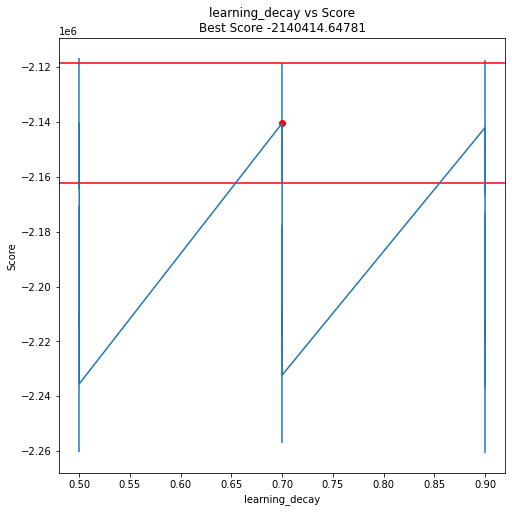

In [ ]:
GridSearch_table_plot(model1, "learning_decay", negative=False)



best parameters: {'learning_decay': 0.7, 'n_components': 10}
best score:      -2140414.64781 (+/-21970.68170)
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,148.449047,1.457942,2.987947,0.062684,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-2.119665e+06,-2.154138e+06,-2.153537e+06,-2.109048e+06,-2.165686e+06,-2.140415e+06,21970.681704,1
0,149.996475,2.317086,3.012890,0.067290,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-2.117189e+06,-2.154384e+06,-2.154591e+06,-2.107183e+06,-2.169314e+06,-2.140532e+06,23979.209511,2
6,150.515363,0.818865,3.053312,0.058434,0.9,10,"{'learning_decay': 0.9, 'n_components': 10}",-2.119848e+06,-2.154109e+06,-2.156104e+06,-2.106908e+06,-2.173080e+06,-2.142010e+06,24631.973639,3
1,160.592777,1.243397,3.476732,0.141635,0.5,20,"{'learning_decay': 0.5, 'n_components': 20}",-2.173504e+06,-2.204777e+06,-2.205721e+06,-2.160562e+06,-2.219949e+06,-2.192903e+06,22176.768680,4
7,160.888753,1.168013,3.482362,0.116324,0.9,20,"{'learning_decay': 0.9, 'n_components': 20}",-2.171279e+06,-2.212120e+06,-2.207792e+06,-2.166487e+06,-2.225172e+06,-2.196570e+06,23368.516504,5
4,159.618910,0.851916,3.489053,0.122102,0.7,20,"{'learning_decay': 0.7, 'n_components': 20}",-2.176413e+06,-2.207445e+06,-2.213647e+06,-2.170542e+06,-2.221028e+06,-2.197815e+06,20416.007552,6
5,181.265699,1.656915,3.944598,0.197673,0.7,30,"{'learning_decay': 0.7, 'n_components': 30}",-2.206702e+06,-2.242164e+06,-2.247913e+06,-2.200200e+06,-2.264497e+06,-2.232295e+06,24752.352165,7
2,180.384641,1.092683,3.888937,0.165097,0.5,30,"{'learning_decay': 0.5, 'n_components': 30}",-2.206469e+06,-2.248174e+06,-2.252993e+06,-2.205507e+06,-2.264369e+06,-2.235503e+06,24667.363644,8
8,181.320543,2.650716,3.980156,0.188137,0.9,30,"{'learning_decay': 0.9, 'n_components': 30}",-2.212911e+06,-2.250716e+06,-2.240515e+06,-2.206576e+06,-2.271987e+06,-2.236541e+06,24204.901601,9


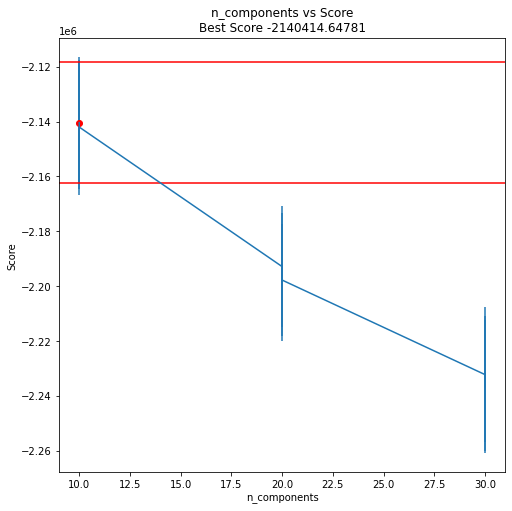

In [ ]:
GridSearch_table_plot(model1, "n_components", negative=False)

In [ ]:
# a utility function to display the topics and for each topic we choose the top most frequent words
def display_topics(model, feature_names, num_top_words):
    for topic_id, topic in enumerate(model.components_):
        print(f'Topic {topic_id}')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

def show_doc_topic_matrix(model, vecs, num_doc_to_show = 10, to_styler=True):
    # model = a trained sklearn lda model
    # vecs = output from the CountVectorizer transform
    lda_output = model.transform(vecs)
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 6), 
                                     columns=[f'topic{i}' for i in range(model.n_components)], 
                                     index=[f'doc{i}' for i in range(vecs.shape[0])])

    # Get dominant topic for each document
    df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)



    # apply style and return the dataframe
    df_out = df_document_topic.head(num_doc_to_show)
    if to_styler:
        return df_out.style.applymap(color_green).applymap(make_bold)
    else:
        return df_out
    
# Styling
def color_green(val):
    if 0 < val < 1:
        color = 'black' if val > .1 else 'grey'
        return f'color: {color}'

def make_bold(val):
    if 0 < val < 1:
        weight = 'bold' if val > .1 else 'lighter'
        return f'font-weight: {weight}'

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,head,gay,god,white,black,horny,eve,man,hair,favourite
Topic 1,work,job,school,money,game,like,time,need,people,live
Topic 2,filler,post,geddit,comment,sub,people,account,edit,like,teenager
Topic 3,fuck,like,shit,day,sleep,hour,come,song,listen,room
Topic 4,talk,like,know,friend,want,help,tell,say,need,ask
Topic 5,want,life,live,die,feel,know,fuck,like,people,think
Topic 6,like,day,people,girl,friend,school,play,think,sex,look
Topic 7,feel,live,like,life,know,think,want,time,thing,people
Topic 8,year,school,parent,want,live,mon,dad,life,family,time
Topic 9,time,live,day,want,year,month,work,know,week,try


In [ ]:
df = show_doc_topic_matrix(best_lda_model, train1_vecs, num_doc_to_show = 20, to_styler=False)
df.style.applymap(color_green).applymap(make_bold)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,dominant_topic
doc0,0.077500,0.217105,0.004168,0.004168,0.497230,0.004168,0.004168,0.004167,0.183158,0.004168,4
doc1,0.004546,0.004547,0.129359,0.004546,0.004547,0.834268,0.004547,0.004547,0.004546,0.004546,5
doc2,0.009092,0.196890,0.381973,0.009092,0.009093,0.009093,0.009093,0.009093,0.009092,0.357489,2
doc3,0.012500,0.012502,0.012500,0.012504,0.012501,0.300797,0.012501,0.012501,0.012502,0.599191,9
doc4,0.009092,0.009093,0.009092,0.473928,0.453327,0.009095,0.009094,0.009094,0.009093,0.009094,3
doc5,0.001177,0.001177,0.001177,0.166670,0.001177,0.424672,0.001177,0.400421,0.001177,0.001177,5
doc6,0.006252,0.006252,0.155077,0.006251,0.006252,0.217228,0.583933,0.006252,0.006251,0.006252,6
doc7,0.009099,0.009092,0.009092,0.230986,0.696263,0.009093,0.009094,0.009093,0.009095,0.009093,4
doc8,0.005556,0.005557,0.175737,0.005557,0.385216,0.005557,0.400148,0.005557,0.005558,0.005557,6
doc9,0.025001,0.025004,0.025000,0.025006,0.025004,0.025000,0.774973,0.025001,0.025007,0.025004,6


In [ ]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(train1_vecs)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(train1_lemmatized_removeSuicide))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.080000,0.220000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.180000,0.000000,4
Doc1,0.000000,0.000000,0.130000,0.000000,0.000000,0.830000,0.000000,0.000000,0.000000,0.000000,5
Doc2,0.010000,0.200000,0.380000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.360000,2
Doc3,0.010000,0.010000,0.010000,0.010000,0.010000,0.300000,0.010000,0.010000,0.010000,0.600000,9
Doc4,0.010000,0.010000,0.010000,0.470000,0.450000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc5,0.000000,0.000000,0.000000,0.170000,0.000000,0.420000,0.000000,0.400000,0.000000,0.000000,5
Doc6,0.010000,0.010000,0.160000,0.010000,0.010000,0.220000,0.580000,0.010000,0.010000,0.010000,6
Doc7,0.010000,0.010000,0.010000,0.230000,0.700000,0.010000,0.010000,0.010000,0.010000,0.010000,4
Doc8,0.010000,0.010000,0.180000,0.010000,0.390000,0.010000,0.400000,0.010000,0.010000,0.010000,6
Doc9,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.770000,0.030000,0.030000,0.030000,6


In [ ]:
!pip install pyldavis pyLDAvis==3.4.0
import pyLDAvis
import pyLDAvis.sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
